In [1]:
# GFLOW
# pip install pytorchvideo==0.1.1
import os
import torch
import random
import numpy as np
import torch.nn.functional as F
from numba import njit,prange
from collections import defaultdict

from tqdm import tqdm
import pandas as pd
import torchvision
from utils import save_to_pickle,load_from_pickle
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation



/home/grads/a/anath/anaconda3/envs/gflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_root_path = "UCF101_subset_whole"
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)

class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Total videos: 0
Unique classes: [].


In [5]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification,VideoMAEFeatureExtractor,VideoMAEModel


image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEModel.from_pretrained("MCG-NJU/videomae-base")
import pytorchvideo.data



from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,

    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    Resize,
)
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

In [6]:
dataset = pytorchvideo.data.labeled_video_dataset(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=transform,
    video_sampler =torch.utils.data.SequentialSampler
)


FileNotFoundError: UCF101_subset_whole/train not found.

In [7]:
def generate_embedding(model,dataset):

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    embeddings = []
    labels = []
    video_names = set()

    file_names = []

    # max_iter =16

    cnt = 0

    # for item in tqdm(dataset):
    for item in tqdm(dataset):
        if item['video_name'] in video_names:
            # print('clip_index',item['clip_index'])
            continue
        else:
            video_names.add(item['video_name'])
            video = item['video']
            video = video.permute(1, 0, 2, 3).unsqueeze(0)
            video = video.to(device)
            with torch.no_grad():
                embedding = model(video).last_hidden_state[:, 0].detach().cpu().squeeze().numpy()

            embeddings.append(embedding)
            labels.append(item['label'])
            file_names.append(item['video_name'])
            cnt +=1 
            if cnt == dataset.num_videos:
                break

    embeddings = np.array(embeddings)
    embeddings = torch.from_numpy(embeddings)
    return embeddings,labels,file_names
# all_embeddings,labels,file_names = generate_embedding(model,dataset=dataset)


In [9]:
# annotations = dict(zip(file_names,labels))

In [10]:
# save_to_pickle(data=annotations,file_path='annotations')

Data has been saved to annotations


In [11]:
# torch.save(all_embeddings, 'all_embeddings.pt')

In [2]:
embeddings=torch.load('all_embeddings.pt')

/tmp/ipykernel_793865/1199666853.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings=torch.load('all_embeddings.pt')


In [3]:
annotations = load_from_pickle('annotations')

Data has been loaded from annotations


In [4]:
annotations_list = list(annotations.values())


In [5]:
embeddings_with_labels =[[annotations_list[idx],embeddings[idx]] 
                         for idx in range(len(annotations_list))]

# Dataset Preprocessing

In [6]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""


    emb_one_normalized = F.normalize(emb_one, p=2, dim=1).double()
    emb_two_normalized = F.normalize(emb_two, p=2, dim=1).double()
    scores= torch.mm(emb_one_normalized, emb_two_normalized.t())
    scores += 1
    scores /=2
    return scores.numpy()

In [11]:
import numpy as np
from numba import njit,prange


@njit(fastmath=True, parallel=True)
def calculate_gains(candidate_similarity, query_similarity, 
                    solution_dense, size_solution, c=2):
    """
    Calculate the gains for each candidate based on the current solution.

    Args:
    candidate_similarity (np.ndarray): A 2D array representing candidate-candidate similarity matrix.
    query_similarity (np.ndarray): A 2D array representing candidate-query similarity matrix.
    solution_dense (np.ndarray): Indices of selected candidates in the solution.
    size_solution (int): Number of selected candidates in the solution.
    c (float): Constant multiplier for query similarity.

    Returns:
    np.ndarray: An array of gains for each candidate.
    """
    num_candidates = len(candidate_similarity)
    gains = np.zeros(num_candidates)

    for candidate in prange(num_candidates):

        gains[candidate] = 10 * np.sum(query_similarity[:,candidate]) - candidate_similarity[candidate, candidate]

        # Adjust gain based on current solution
        for selected_idx in range(size_solution):
            selected_candidate = solution_dense[selected_idx]
            gains[candidate] -= 2 * candidate_similarity[candidate, selected_candidate]
        # gains[candidate] = gain

    return gains

# @njit(fastmath=True, parallel=True)
def graph_cut(candidate_similarity, query_similarity,costs, budget, ground_set):
    """
    Perform the graph cut optimization to maximize similarity between candidates and the query.

    Args:
    candidate_similarity (np.ndarray): A 2D array representing candidate-candidate similarity matrix.
    query_similarity (np.ndarray): A 2D array representing candidate-query similarity matrix.
    budget (int): The number of candidates to select.
    ground_set (list or np.ndarray): Set of candidate elements.

    Returns:
    obj_val (float): The final objective value achieved.
    solution_dense (np.ndarray): Indices of selected candidates.
    solution_sparse (np.ndarray): Sparse solution with binary representation (selected candidates are marked 1).
    """

    num_candidates = len(candidate_similarity)

    # Initialize variables
    solution_sparse = np.zeros(num_candidates)
    solution_dense = np.zeros(num_candidates, dtype=np.int32)
    size_solution = 0
    obj_val = 0.0
    c = 2  # Constant multiplier for query similarity

    # Loop over the budget to select candidates
    # for _ in range(budget):

    constraint = 0
    while True:
        # Calculate gains for all candidates
        gains = calculate_gains(candidate_similarity, query_similarity, 
                                solution_dense, size_solution, c)

        best_candidate = -1
        max_gain_ratio = 0 # Initialize max_gain to negative infinity to ensure the first gain is selected
        
        for i in range(num_candidates):
            if ground_set[i] == 1 and solution_sparse[i] == 0:  # Check if candidate is eligible (not already selected)
                if gains[i]/costs[i] > max_gain_ratio :  # Find the candidate with the maximum gain
                    max_gain_ratio = gains[i]/costs[i]
                    best_candidate = i

        if best_candidate == -1:
            # No valid candidate was found, stop the loop
            print("No valid candidate found, breaking the loop.")
            break
        
        ground_set[best_candidate] = 0
        # Select the candidate with the highest gain

        if costs[best_candidate]+constraint <= budget:
            solution_dense[size_solution] = best_candidate
            solution_sparse[best_candidate] = 1
            size_solution += 1
            obj_val += gains[best_candidate]


    return obj_val, solution_dense[:size_solution], solution_sparse


In [12]:
import numpy as np


@njit(fastmath=True, parallel=True)
def QS(candidate_similarity, query_similarity,costs, delta=0.05, budget=5):
    N = len(candidate_similarity)
    print('Size of unpruned ground set', N)

    # Current objective value
    curr_obj = 0

    # Ground set, dense and sparse solutions
    ground_set = np.zeros(N)
    solution_dense = np.zeros(N, dtype=np.int32)
    solution_sparse = np.zeros(N)
    size_solution = 0

    for element in range(N):
        gains = calculate_gains(candidate_similarity, query_similarity, 
                                solution_dense, size_solution, solution_sparse)

        gain = gains[element]

        if gain/costs[element] >= delta / budget * curr_obj:
            curr_obj += gain
            # Mark the element as selected in the ground set
            ground_set[element] = 1
            solution_sparse[element] = 1
            solution_dense[size_solution] = element
            size_solution += 1

    print('Size of pruned ground set(QS)', ground_set.sum())
    return ground_set



In [13]:
random.shuffle(embeddings_with_labels)

In [14]:
all_candidate_embeddings_with_labels = embeddings_with_labels[:6000]
all_query_embeddings_with_labels = embeddings_with_labels[6000:]

In [15]:
all_candidate_embeddings= [item[1] for item in all_candidate_embeddings_with_labels]
all_query_embeddings = [item[1] for item in all_query_embeddings_with_labels]

all_candidate_labels= np.array([item[0] for item in all_candidate_embeddings_with_labels])
all_query_labels = np.array([item[0] for item in all_query_embeddings_with_labels])
all_candidate_embeddings = torch.stack(all_candidate_embeddings,dim=0)
all_query_embeddings = torch.stack(all_query_embeddings,dim=0)

In [21]:
queries_indices = [100,0]

query_embeddings=all_query_embeddings[[queries_indices]]
print(all_query_labels[queries_indices])


candidate_similarity = compute_scores(all_candidate_embeddings,all_candidate_embeddings)
query_similarity = compute_scores(query_embeddings,all_candidate_embeddings)

[79 19]


In [22]:
import random
from tqdm import tqdm
import heapq

def calculate_obj(candidate_similarity,query_similarity,solution):

    obj_val = 0
    # print(solution)
    for candidate in solution:
        obj_val += 10 * np.sum(query_similarity[:,candidate])


    solution = list(solution)

    for  i in range(len(solution)):
        for j in range(i+1,len(solution)):
            obj_val -= candidate_similarity[i,j]

    return obj_val



In [24]:


df = defaultdict(list)
delta = 0.01


costs = np.ones(candidate_similarity.shape[0])


for budget in [5,10,15,20]:

    N = len(candidate_similarity)

    ground_set_QS = QS(candidate_similarity,query_similarity,costs,delta,budget)
    # size_SS = round(np.sum(ground_set_SS)/len(ground_set_SS)*100,4)
    size_QS = round(np.sum(ground_set_QS)/len(ground_set_QS)*100,4)
    retrived_images = np.where(ground_set_QS==1)[0]

    ### top-k

    gains = calculate_gains(candidate_similarity=candidate_similarity,
                            query_similarity=query_similarity,
                            solution_dense=np.zeros(N, dtype=np.int32),
                            size_solution=0)
    
    top_k_elements = np.argsort(gains)[::-1][:int(np.sum(ground_set_QS))]

    ground_set_top_k = np.zeros(N)
    for element in top_k_elements:
        ground_set_top_k[int(element)] = 1

    obj_val_top_k,solution_top_k,_=graph_cut(candidate_similarity=candidate_similarity,
                            query_similarity=query_similarity,costs=costs,
                            budget=budget,ground_set=ground_set_top_k)
    


    obj_val_FS_QS,solution_FS_QS,_=graph_cut(candidate_similarity=candidate_similarity,
                            query_similarity=query_similarity,costs=costs,
                            budget=budget,ground_set=ground_set_QS)
    
    

    

    obj_val_FS,solution_FS,_=graph_cut(candidate_similarity=candidate_similarity,
                            query_similarity=query_similarity,costs=costs,
                            budget=budget,ground_set=np.ones(N))
    
    num_repeat = 5
    obj_val_FS_Random = 0
    for i in range(num_repeat):
        # Randomly select a mask
        random_mask = np.random.choice(np.arange(N), 
                                       size=int(ground_set_QS.sum()), replace=False)
        
        # Create the random ground set
        random_ground_set = np.zeros(N)
        random_ground_set[random_mask] = 1 
        
        # Calculate the objective value using graph_cut
        temp_obj_val_FS_Random,solution_FS_Random,_= graph_cut(candidate_similarity=candidate_similarity,
                                    query_similarity=query_similarity,
                                    budget=budget,costs=costs,
                                    ground_set=random_ground_set)
        
        obj_val_FS_Random+=temp_obj_val_FS_Random

        
    
    obj_val_FS_Random /= num_repeat


    df['Budget'].append(budget)
    df['Ratio_Obj(QS)'].append(obj_val_FS_QS/obj_val_FS)
    df['Ratio_Obj(top-k)'].append(obj_val_top_k/obj_val_FS)
    # df['Ratio_Obj(FS+QS)'].append(obj_val_FS_QS)
    df['Pg(QS)'].append(size_QS)
    df['Obj(FS)'].append(obj_val_FS)
    df['Ratio_Obj(Random)'].append(obj_val_FS_Random/obj_val_FS)
    # df['Ratio_Obj(FS+Random)'].append(obj_val_FS_Random)

    # break
    
    

  

df = pd.DataFrame(df)
df.to_pickle(f'video_UCF101')
print(df)

Size of unpruned ground set 6000
Size of pruned ground set(QS) 9.0
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
Size of unpruned ground set 6000
Size of pruned ground set(QS) 10.0
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
No valid candidate found, breaking the loop.
Size of unpruned ground set 6000
Size of pruned ground set(QS) 10.0
No valid candidate found, breaking the loop.
No valid candidate found, breaki

In [137]:
# all_query_labels[queries_indices]

array([60])

In [138]:
all_candidate_labels[solution_FS_Random]

array([71])

In [139]:
all_candidate_labels[solution_FS]

array([60, 11,  6, 47, 38])

In [140]:
all_candidate_labels[solution_FS_QS]

array([ 5, 76, 40, 93, 91])

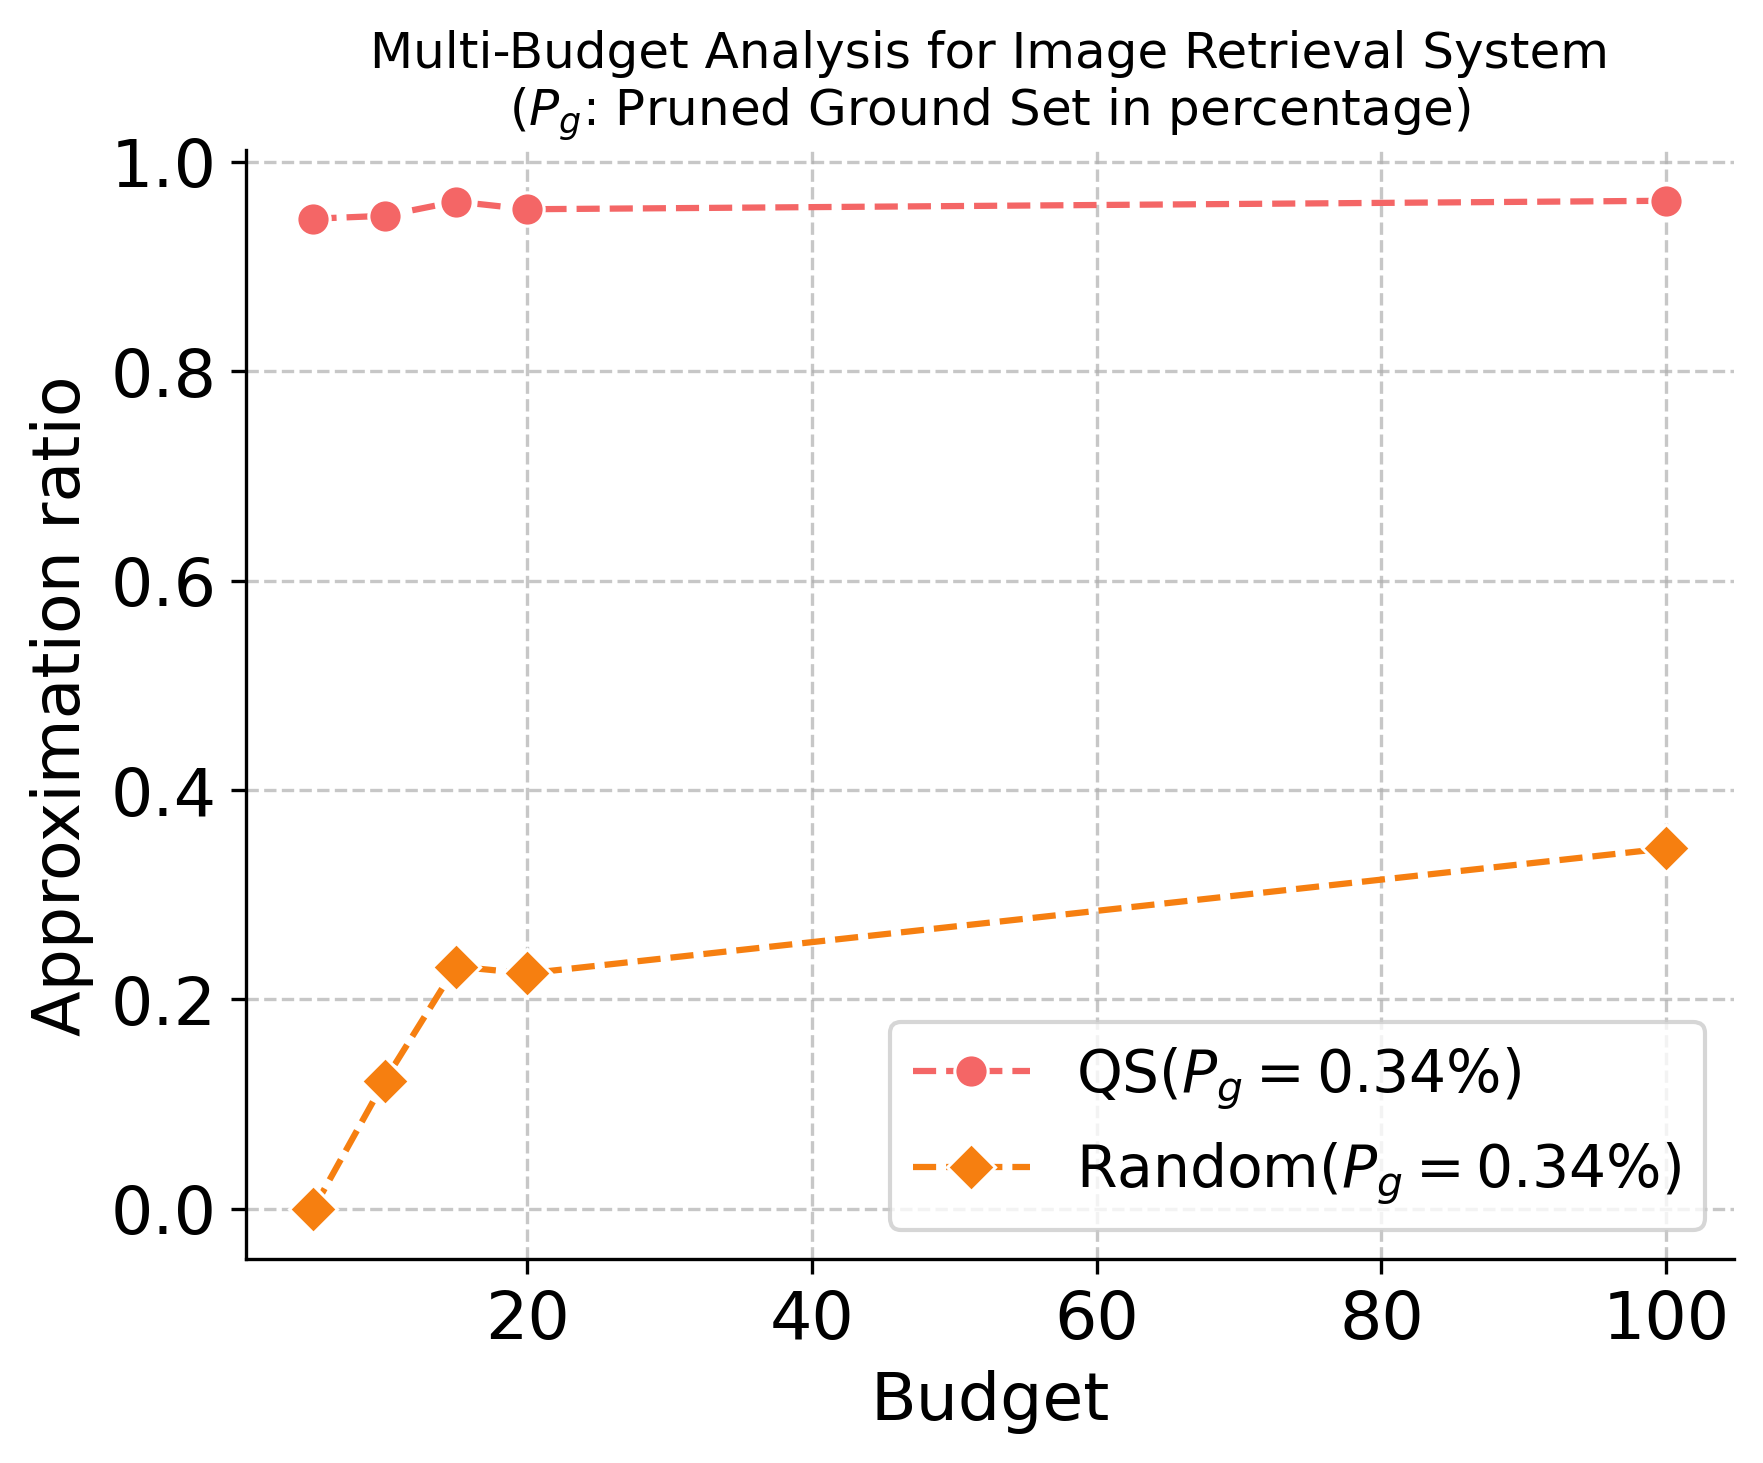

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(dpi=300)

# Plotting the ratios with larger markers and improved styling
sns.lineplot(data=df, x='Budget', y='Ratio_Obj(FS+QS)', label='QS$(P_g=0.34\%)$', linestyle='--', marker='o', 
             markersize=8, color='#f46666')
# sns.lineplot(data=df, x='Budget', y='Ratio_Obj(FS+SS)', label='SS$(P_g=28.89\%)$',linestyle='--' ,marker='s', 
#              markersize=8, color='#37a1e2')
sns.lineplot(data=df, x='Budget', y='Ratio_Obj(FS+Random)', label='Random$(P_g=0.34\%)$',linestyle='--', marker='D', 
             markersize=8, color='#f67f10')

# Labeling the plot
# plt.title('Ratios of Different Objectives Relative to Obj(FS)')
# plt.xlabel('Budget')
# plt.ylabel('Ratio')
# plt.legend(title='Objective', title_fontsize='13', fontsize='11')

fontsize = 16

# plt.title('Multi Budget results for Image retrival system \n $P_g =$ percentage of the ground set')
plt.title('Multi-Budget Analysis for Image Retrieval System\n($P_g$: Pruned Ground Set in percentage)')

plt.xlabel('Budget',fontsize=fontsize)
plt.ylabel('Approximation ratio',fontsize=fontsize)

plt.xticks(fontsize=fontsize )
plt.yticks(fontsize=fontsize )

# Adding a light grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.locator_params(nbins=6)
# Legend
plt.legend(fontsize='14')
sns.despine()

# Show the plot
plt.show()
